In [ ]:
!pip install validators

In [ ]:
!wget https://jlucasmckay.bmi.emory.edu/global/bmi500/gait-json.zip
!unzip gait-json.zip

In [37]:
# # Lab Part 2
# 
# 1. Write a function to calculate included angle from two vectors
# 2. Identify gait speed vs. time
# 3. Identify ankle height vs. time (R, L)
# 4. Identify knee angle vs. time (R, L)
# 5. Set up pandas dataframe with outcome variables
# 6. Code rows in dataframe by participant
# 7. Plot the data

# In[1]:


# imports etc.
import validators
from pathlib import Path
import urllib.request
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set_theme()


# # Base functions for interacting with .json files
# 
# The following routines allow you to load and make a basic plot of a `.json` file from OpenPose.

In [2]:
# In[2]:


def extract_kp_from_resource(f,person_id = -1):
    """
    Extract keypoints from resource (file or url) as a numpy vector
    """

    # load json from remote if it is an url; otherwise load as file
    if validators.url(f):
        json_temp = json.load(urllib.request.urlopen(u))['people']
    if Path(f).exists():
        json_temp = json.load(open(f))['people']
    
    try:
        # extract the keypoints of the person specified by person_id; default is last person identified
        keypoints = np.array(extract_kp_from_json(json_temp)["pose_keypoints_2d"][person_id]).astype('float')
    except:
        keypoints = np.empty((75,))
        keypoints[:] = np.NaN
    
    # set missing points (imputed as 0) to nan so that they are not plotted
    keypoints[keypoints==0] = np.nan
    
    return keypoints

def extract_kp_from_json(json_people):
    """
    subfunction for extract_kp_from_resource
    """
    person_id = []
    pose_keypoints_2d = []
    for i in range(0,len(json_people)):
        person_id.append(json_people[i]["person_id"])
        pose_keypoints_2d.append(json_people[i]["pose_keypoints_2d"])
    # return a dict
    return {'person_id': person_id, 'pose_keypoints_2d': pose_keypoints_2d}

def convert_kp_to_df(keypoints):
    """
    reshape keypoint vector to dataframe
    """
    # reshape to 25 X 3; the coordinates are x, y, confidence in estimate
    kin = keypoints.reshape((-1,3))
        
    # create a dataframe
    df = pd.DataFrame({'keypoint': ["Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar", "LBigToe", "LSmallToe", "LHeel", "RBigToe", "RSmallToe", "RHeel"], 'x': kin[:,0], 'y': kin[:,1], 'confidence': kin[:,2]})

    return df.set_index('keypoint')

def plot_body25_df(df):
    """
    plot a dataframe corresponding to body25 coordinates
    """
    segments = [['Neck', 'REar', 'LEar', 'Neck'],
        ['Nose', 'REye', 'LEye', 'Nose'],
        ['RShoulder', 'Neck', 'LShoulder','RShoulder'],
        ["LShoulder", "LElbow", "LWrist"],
        ["RShoulder", "RElbow", "RWrist"],
        ['RShoulder', 'RHip', 'LHip','LShoulder','RShoulder'],
        ['LHip', 'MidHip', 'RHip'],
        ["LHip", "LKnee", "LAnkle"],
        ["RHip", "RKnee", "RAnkle"],
        ['LAnkle', 'LHeel', 'LBigToe', 'LSmallToe', 'LAnkle'],
        ['RAnkle', 'RHeel', 'RBigToe', 'RSmallToe', 'RAnkle']]
    
    fig, ax = plt.subplots()
    ax.set(xlim=[0, 1920], ylim=[1080, 0], xlabel='X', ylabel='Y')  # setting the correct parameters from the slides
    [sns.lineplot(data=df_f.loc[s], x = "x", y = "y", ax = ax) for s in segments]


In [6]:
# # Sample load and plot
# 
# Here is a sample of how to load/plot from a local file or online resource

# In[9]:


u = "https://jlucasmckay.bmi.emory.edu/global/bmi500/keypoints.json"
f = "keypoints.json"

kp_u = extract_kp_from_resource(u)
kp_f = extract_kp_from_resource(f)

df_u = convert_kp_to_df(kp_u)
df_f = convert_kp_to_df(kp_f)
df_f

,x,y,confidence
keypoint,,,
Nose,839.275,274.261,0.917512
Neck,806.930,347.775,0.878199
RShoulder,762.852,347.858,0.865138
RElbow,727.486,442.062,0.822156
RWrist,709.782,530.354,0.871983
LShoulder,842.340,344.855,0.844136
LElbow,856.942,430.125,0.889750
LWrist,921.665,459.668,0.859753
MidHip,809.972,512.606,0.826453


In [7]:
# # Functions to calculate outcomes
# 
# To complete the lab, you must fill in the following function prototypes:
# 
# ```python
def calculate_angle(v1,v2):
    """
    return the angle (in degrees) between two vectors v1 and v2.
    """
    product = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
    # Calulate the angle between the two vectors
    angle = np.arccos(product)
    return angle

In [30]:
def df_to_outcomes(d):
    """
    return a dataframe with kinematic outcomes derived from a single body25 dataframe.
    one row, name of the file, angel
    """
    # Left Knee angle
    l_knee_ang = calculate_angle(np.array([d.loc['LKnee','x']-d.loc['LHip','x'], d.loc['LKnee','y']-d.loc['LHip','y']]),
                np.array([d.loc['LKnee','x']-d.loc['LAnkle','x'], d.loc['LKnee','y']-d.loc['LAnkle','y']])) 
    # Right Knee angle
    r_knee_ang = calculate_angle(np.array([d.loc['RKnee','x']-d.loc['RHip','x'], d.loc['RKnee','y']-d.loc['RHip','y']]),
                np.array([d.loc['RKnee','x']-d.loc['RAnkle','x'], d.loc['RKnee','y']-d.loc['RAnkle','y']]))
    # Right Toe Height
    r_toe_ht = (d.loc['RBigToe','y'] + d.loc['RSmallToe','y'])/2
    # Left Toe Height
    l_toe_ht = (d.loc['LBigToe','y'] + d.loc['LSmallToe','y'])/2
    # Center x
    com_x = ((d.loc['RShoulder','x']+d.loc['LShoulder','x'])/2 + (d.loc['RHip','x']+d.loc['LHip','x'])/2)/2
    # Center y
    com_y = ((d.loc['RShoulder','y']+d.loc['LShoulder','y'])/2 + (d.loc['RHip','y']+d.loc['LHip','y'])/2)/2
    # Output df
    out_df = pd.DataFrame({'r_knee_ang':[r_knee_ang], 'l_knee_ang':[l_knee_ang], 'r_toe_ht':[r_toe_ht], 'l_toe_ht':[l_toe_ht], 'com_x':[com_x], 'com_y':[com_y]})
    return out_df


In [31]:
# Run on the sampe df
df_to_outcomes(df_f)

,r_knee_ang,l_knee_ang,r_toe_ht,l_toe_ht,com_x,com_y
0,2.768707,2.764229,796.6775,780.486,806.95,429.49


In [32]:
def calc_outcomes(f):
    """
    calculate outcomes from a file or other resource
    return as a dataframe in standard format
    """
    out_df = df_to_outcomes(convert_kp_to_df(extract_kp_from_resource(f)))
    return out_df

In [34]:
# Test on the sample json file
calc_outcomes("/content/keypoints.json")

,r_knee_ang,l_knee_ang,r_toe_ht,l_toe_ht,com_x,com_y
0,2.768707,2.764229,796.6775,780.486,806.95,429.49


In [40]:
# Show the folder tree
def folder_tree(root_dir):
  for path in Path(root_dir).iterdir():
      if path.is_dir():
          print(path)
folder_tree("/content/json")

/content/json/11, 10-25, Vaulting gait opposite side, Sag, Paige
/content/json/3, 10-25, R Hemi gait, Sag, Zach
/content/json/7, 10-25, Ataxic gait, Sag, Zach
/content/json/2, 10-25, Normal gait, Sag, Zach
/content/json/6, 10-25, Circum hip gait, Paige
/content/json/5, 10-25, Crouch Gait, Sag, Zach
/content/json/8, 10-25, Limping gait, Sag, Zach
/content/json/1, 10-25, Normal gait, Sag, Paige
/content/json/4, 10-25, Vaulting gait, Sag, Paige
/content/json/9, 10-25 Circum hip L gait, Sag, Paige
/content/json/10, 10-25, Trendel gait, Sagittal, Paige


In [92]:
# In[10]:
root_dir = Path("/content/json")
# ADD FUNCTIONS HERE
def file_looper(root_dir):
  # Loop over the files
  df_list = []
  for file in root_dir.glob("*/*.json"):
    out_df = calc_outcomes(str(file))
    out_df["trail"] = str(file.parent.stem)
    out_df["frame"] = str(file).split("_")[1]
    df_list.append(out_df)
  return df_list

def outcome_generator(root_dir):
  root_dir = root_dir
  # Generate the list of outcome
  df_list = file_looper(root_dir)
  # Concatenate the outcomes
  df_outcomes = pd.concat(df_list, ignore_index=True)
  # Sort within trail groups
  df_outcomes.sort_values(["trail", "frame"], ignore_index=True, inplace=True)
  # Save as the csv
  df_outcomes.to_csv("outcomes.csv")
  return df_outcomes

In [94]:
df_outcomes = outcome_generator(root_dir)
df_outcomes.head(10)

,r_knee_ang,l_knee_ang,r_toe_ht,l_toe_ht,com_x,com_y,trail,frame
0,NaN,NaN,NaN,NaN,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000000
1,NaN,NaN,NaN,NaN,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000001
2,NaN,3.141134,NaN,786.3080,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000002
3,NaN,3.141168,NaN,NaN,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000003
4,NaN,3.140445,NaN,651.0385,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000004
5,NaN,3.141138,NaN,786.3125,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000005
6,NaN,NaN,NaN,NaN,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000006
7,NaN,3.131581,NaN,652.4945,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000007
8,NaN,3.129043,NaN,786.1955,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000008
9,NaN,NaN,NaN,NaN,NaN,NaN,"1, 10-25, Normal gait, Sag, Paige",000000000009


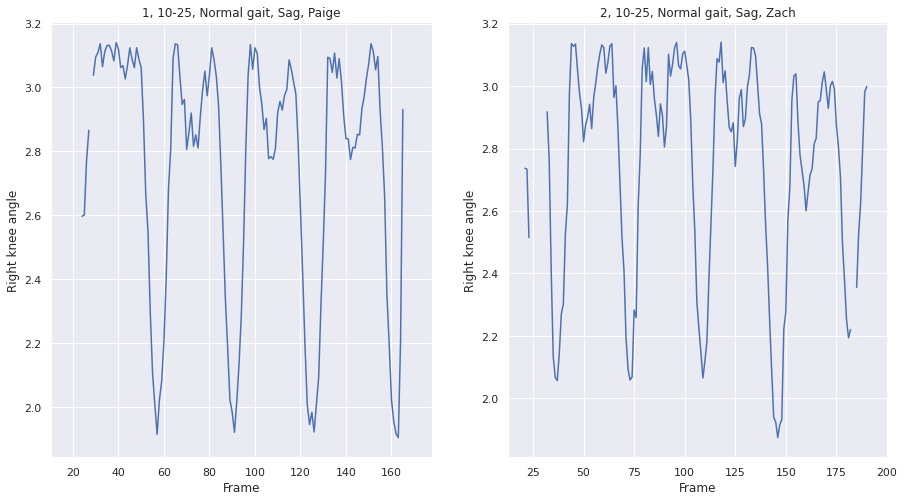

In [143]:
# # Plot and save
# 
# ## Normal gait (right knee angle, first 200 frames)

# In[12]:

# ADD PLOT CODE

# ## Vaulting gait (right knee angle, first 200 frames)

# In[13]:

# ADD PLOT CODE

# # What to turn in
# 
# 1. A completed notebook with documented code
# 2. The aggregated csv file
counter = 1
plt.subplots(figsize=(15, 8))
for gait in ["1, 10-25, Normal gait, Sag, Paige", "2, 10-25, Normal gait, Sag, Zach"]:
  temp_df = df_outcomes[df_outcomes["trail"]==gait][["r_knee_ang", "frame"]]
  plt.subplot(1, 2, counter)
  plt.plot(np.array(range(int(temp_df.frame.iloc[-1])+1)), temp_df.r_knee_ang)
  plt.xlabel("Frame")
  plt.ylabel("Right knee angle")
  plt.title(gait)
  counter += 1
plt.show()

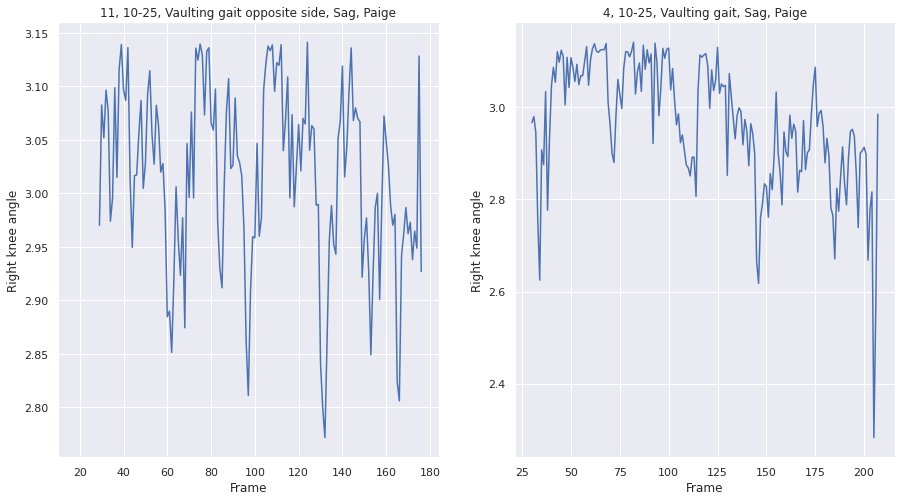

In [144]:
counter = 1
plt.subplots(figsize=(15, 8))
for gait in ["11, 10-25, Vaulting gait opposite side, Sag, Paige", "4, 10-25, Vaulting gait, Sag, Paige"]:
  temp_df = df_outcomes[df_outcomes["trail"]==gait][["r_knee_ang", "frame"]]
  plt.subplot(1, 2, counter)
  plt.plot(np.array(range(int(temp_df.frame.iloc[-1])+1)), temp_df.r_knee_ang)
  plt.xlabel("Frame")
  plt.ylabel("Right knee angle")
  plt.title(gait)
  counter += 1
plt.show()